In [21]:
import gsw
import matplotlib.pyplot as plt
from matplotlib.ticker import MultipleLocator
import numpy as np
import xarray as xr

from acspype import ACSDev
from acspype import ACSTSCor
import acspype.processing as acsproc
import acspype.qaqc as acsqaqc
from acspype.tscor import ACSTSCor

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [22]:
data_filepath = '../dev_tools/test_files/TEST_SHIMADA_202405.nc'
acs = xr.open_dataset(data_filepath)

In [23]:
dev_filepath = '../dev_tools/test_files/ACS-00412_2023-05-10.dev'
dev = ACSDev(dev_filepath)
dev.to_xarray()

<xarray.Dataset> Size: 53kB
Dimensions:          (a_wavelength: 89, c_wavelength: 89, temperature_bin: 35)
Coordinates:
  * a_wavelength     (a_wavelength) float64 712B 401.9 403.9 ... 738.5 742.3
  * c_wavelength     (c_wavelength) float64 712B 401.4 403.9 ... 738.1 741.8
  * temperature_bin  (temperature_bin) float64 280B 0.8352 1.201 ... 33.5 34.52
Data variables:
    a_offset         (a_wavelength) float64 712B -0.04384 0.01841 ... -0.2669
    a_delta_t        (a_wavelength, temperature_bin) float64 25kB -0.004055 ....
    c_offset         (c_wavelength) float64 712B 0.9704 1.075 ... -0.7509
    c_delta_t        (c_wavelength, temperature_bin) float64 25kB 0.01514 ......
Attributes: (12/25)
    device_filepath:                ../dev_tools/test_files/ACS-00412_2023-05...
    sensor_type:                    ACS Meter
    serial_number_hexdec:           5300019C
    serial_number:                  ACS-00412
    device_file_structure_version:  3
    tcal:                           22.5
    ...                             ...
    max_c_difference:               0.0
    min_a_counts:                   0.0
    min_c_counts:                   0.0
    min_r_counts:                   0.0
    max_temp_sd:                    0.0
    max_depth_sd:                   0.0

In [24]:
acs

<xarray.Dataset> Size: 49MB
Dimensions:                            (time: 16622, a_wavelength: 89,
                                        c_wavelength: 89)
Coordinates:
  * time                               (time) datetime64[ns] 133kB 2024-06-03...
  * a_wavelength                       (a_wavelength) float64 712B 401.9 ... ...
  * c_wavelength                       (c_wavelength) float64 712B 401.4 ... ...
Data variables: (12/13)
    latitude                           (time) float64 133kB ...
    longitude                          (time) float64 133kB ...
    raw_internal_temperature           (time) int64 133kB ...
    raw_external_temperature           (time) int64 133kB ...
    a_signal                           (time, a_wavelength) int64 12MB ...
    a_reference                        (time, a_wavelength) int64 12MB ...
    ...                                 ...
    c_reference                        (time, c_wavelength) int64 12MB ...
    elapsed_time                       (time) int64 133kB ...
    sea_water_temperature              (time) float64 133kB ...
    sea_water_electrical_conductivity  (time) float64 133kB ...
    sea_water_practical_salinity       (time) float64 133kB ...
    seawater_state                     (time) float64 133kB ...
Attributes: (12/13)
    acs_serial_number:           ACS412
    acs_device_file:             ACS0412_2023-05-10.DEV
    acs_num_output_wavelengths:  89
    flow_meter_serial_number:    11222239
    flowmeter_kfactor:           617.2
    flowmeter_manufacturer:      Omega
    ...                          ...
    tsg_serial_number:           tsg00001
    tsg_manufacturer:            Atlas Scientific
    tsg_model:                   Industrial Conductivity Probe K1.0
    valve_serial_number:         valve00001
    dataset_description:         This is a curated dataset of ACS and ancilla...
    dataset_owner:               Maria T. Kavanaugh, Oregon State University

In [30]:
acs.raw_internal_temperature.head()

<xarray.DataArray 'raw_internal_temperature' (time: 5)> Size: 40B
[5 values with dtype=int64]
Coordinates:
  * time     (time) datetime64[ns] 40B 2024-06-03T02:30:00.239508 ... 2024-06...

Text(0.5, 1.0, 'Absorption Signal at 440 nm')

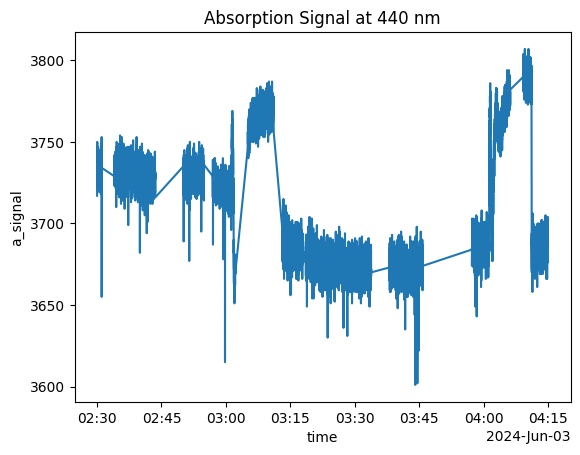

In [26]:
# using time/signal as array, wavelength as coordinate
absorption_signal = acs['a_signal']
absorption_wavelength = acs['a_wavelength'].values
absorption_arrays = [absorption_signal.sel(a_wavelength=wavelength) for wavelength in absorption_wavelength]
absorption_arrays[0].plot()
plt.title('Absorption Signal at 440 nm')


In [29]:
absorption_wavelength

array([401.9, 403.9, 405.7, 407.8, 409.6, 411.7, 414.4, 418. , 422.1,
       427.4, 431.8, 435.5, 439.1, 442.8, 447.4, 451.5, 455. , 458.9,
       463.4, 466.6, 470.8, 476.1, 480.4, 485. , 488.8, 493. , 497.4,
       501.4, 505.5, 510.2, 514.9, 519. , 523.7, 527.5, 531.8, 535.4,
       539.4, 543. , 547.1, 551. , 555.2, 559.4, 563.2, 567.3, 571. ,
       574.6, 576.1, 579.8, 583.4, 587.3, 591.2, 595.4, 599.8, 604.3,
       608.8, 613.2, 617.9, 622.5, 626.2, 630.2, 634.2, 638.8, 642.5,
       646.9, 651.7, 655.8, 660.3, 664.4, 668.8, 673.1, 677.5, 681.2,
       685.1, 688.9, 693.3, 696. , 700. , 703.6, 707. , 710.7, 714.2,
       717.7, 721.4, 724.9, 728.3, 731.8, 734.8, 738.5, 742.3])

In [ ]:
attenuation_signal = acs['c_signal']
attenuation_wavelength = acs['c_wavelength'].values
attenuation_arrays = [attenuation_signal.sel(c_wavelength=wavelength) for wavelength in attenuation_wavelength]
attenuation_arrays[0].plot()
plt.title('Attenuation Signal at 440 nm')

In [ ]:
a_signal = acs['a_signal']
a_reference = acs['a_reference']
c_signal = acs['c_signal']
c_reference = acs['c_reference']

a_reference[0].plot()
a_signal[0].plot()


In [ ]:
a_signal.head()

<xarray.DataArray 'a_signal' (time: 5, a_wavelength: 5)> Size: 200B
array([[ 3717,  5732,  8340, 10945, 12886],
       [ 3742,  5711,  8328, 10961, 12870],
       [ 3737,  5715,  8337, 10957, 12877],
       [ 3731,  5706,  8340, 10945, 12871],
       [ 3729,  5708,  8322, 10948, 12879]])
Coordinates:
  * time          (time) datetime64[ns] 40B 2024-06-03T02:30:00.239508 ... 20...
  * a_wavelength  (a_wavelength) float64 40B 401.9 403.9 405.7 407.8 409.6

In [ ]:
acs.acs_serial_number

'ACS412'

In [ ]:
dev.serial_number

'ACS-00412'